# Кластеризация данных о посещениях сайтов

# Импорт и преподготовка данных

In [1]:
#Импортируем необходимые библиотеки
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
#Увеличим число отображаемых столбцов
pd.set_option('display.max_columns', 100)

In [3]:
# Импортируем данные
data = pd.read_csv('data.csv')
data.date = pd.to_datetime(data.date)
data = data.set_index(['date'])
data.head()

,event_id,cookie_id,session_id,event_type,domain_id
date,,,,,
2020-08-18 00:00:01.065710,092656bc-da3a-42b2-87b2-bc7349cf1e91,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,f6ffb2a7-dfbd-40d7-ad25-a08c5a3a1323,read_block ...,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
2020-08-18 00:00:01.066429,4ee06cf5-24cc-478f-9acf-4e286516177f,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,f6ffb2a7-dfbd-40d7-ad25-a08c5a3a1323,read_block ...,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
2020-08-18 00:00:02.582822,ddc54ec1-46de-48ee-b906-9d8ce3d64b37,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,f6ffb2a7-dfbd-40d7-ad25-a08c5a3a1323,read_block ...,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
2020-08-18 00:00:02.582836,a34f5180-a533-4dd0-bb0c-a61bfb40b74a,9e2c1cf7-83a4-4fcf-9d87-63e316a0c91f,f6ffb2a7-dfbd-40d7-ad25-a08c5a3a1323,read_block ...,a1fb2d2a-9c3e-49e2-a651-cf52fbf0212a
2020-08-18 00:00:03.225834,962ae9a7-b768-46e2-b9bd-48dcdc78d0d9,b82ab5d5-228b-4f41-89c4-4eb74bfb4653,8645bfcd-c7be-4014-9f83-0c78be8d1f21,read_block ...,34308d56-1149-42a1-a0d9-5652c915ac9e


In [4]:
#Проверим на наличие пропущенных значений
data.isnull().sum()

event_id      0
cookie_id     0
session_id    0
event_type    0
domain_id     0
dtype: int64

In [5]:
#Посмотрим размерность данных
data.shape

(4124734, 5)

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4124734 entries, 2020-08-18 00:00:01.065710 to 2020-09-08 23:59:54.218274
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   event_id    object
 1   cookie_id   object
 2   session_id  object
 3   event_type  object
 4   domain_id   object
dtypes: object(5)
memory usage: 188.8+ MB
None


In [7]:
# Извлечем из даты такие признаки как час, день недели и выходной ли этот день
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data = data.reset_index()

#Перекодируем признаки
labelencoder = LabelEncoder()


data['domain_id'] = labelencoder.fit_transform(data['domain_id'])
data['session_id'] = labelencoder.fit_transform(data['session_id'])
data['cookie_id'] = labelencoder.fit_transform(data['cookie_id'])
data['event_id'] = labelencoder.fit_transform(data['event_id'])

data.head()

,date,event_id,cookie_id,session_id,event_type,domain_id,hour,weekday,is_weekend
0,2020-08-18 00:00:01.065710,147840,102982,231455,read_block ...,6,0,1,0
1,2020-08-18 00:00:01.066429,1270509,102982,231455,read_block ...,6,0,1,0
2,2020-08-18 00:00:02.582822,3572350,102982,231455,read_block ...,6,0,1,0
3,2020-08-18 00:00:02.582836,2630228,102982,231455,read_block ...,6,0,1,0
4,2020-08-18 00:00:03.225834,2419045,119943,126137,read_block ...,2,0,1,0


In [8]:
#Провери на наличие дубликатов
event = pd.DataFrame(data['event_id'].value_counts()).reset_index()
print(event.event_id.unique())

[1]


# Проведем анализ данных

In [9]:
# Посмотрим как распределены типы события
print(pd.DataFrame(data['event_type'].value_counts(normalize = True)).reset_index())

                                                index  event_type
0   read_block                                    ...    0.616130
1   click                                         ...    0.145552
2   visit                                         ...    0.092128
3   filter_change                                 ...    0.081159
4   hover                                         ...    0.017983
5   choose_flat                                   ...    0.012246
6   change_resolution                             ...    0.010731
7   filter_mortgage_change                        ...    0.010708
8   callback_exit                                 ...    0.009405
9   Choose_flat                                   ...    0.002134
10  change_slider                                 ...    0.001312
11  click_scbform_button_callrequest              ...    0.000305
12  submit_flat_applicaiton_click                 ...    0.000063
13  callback_start                                ...    0.000034
14  clcik 

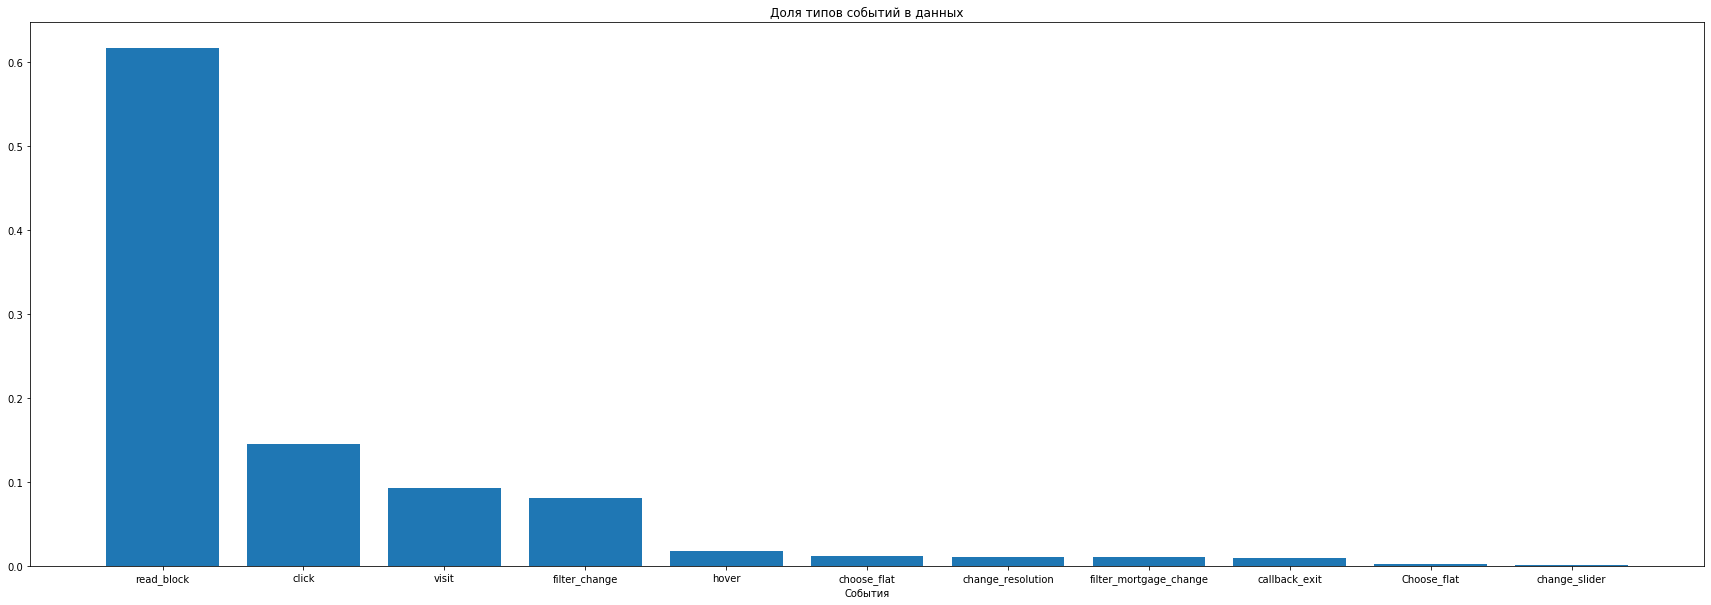

In [10]:
# Нарисуем расположенные выше результаты
count_event = pd.DataFrame(data['event_type'].value_counts(normalize = True)).reset_index()
count_event['index'] = count_event['index'].replace(r'\s+','',regex=True)
plt.figure(figsize = (30,10))
plt.bar(count_event['index'][0:11],count_event['event_type'][0:11])
plt.title('Доля типов событий в данных')
plt.xlabel('События')
plt.show()

In [11]:
# Посмотрим на распределние сайтов
pd.DataFrame(data['domain_id'].value_counts(normalize = True)).reset_index()

,index,domain_id
0,5,0.285882
1,0,0.282408
2,6,0.243413
3,3,0.057134
4,2,0.040751
5,1,0.036545
6,4,0.031066
7,7,0.012354
8,8,0.010447


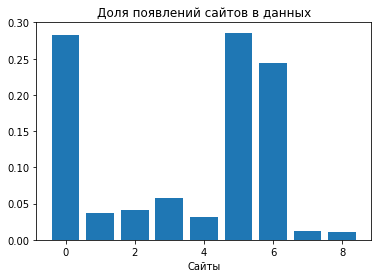

In [12]:
domain = pd.DataFrame(data['domain_id'].value_counts(normalize = True)).reset_index()
plt.bar(domain['index'],domain['domain_id'])
plt.title('Доля появлений сайтов в данных')
plt.xlabel('Сайты')
plt.show()

In [13]:
# Посмотрим на то как часто встречаются одинаковые пользователи
cokie = pd.DataFrame(data['cookie_id'].value_counts()).reset_index()
cokie

,index,cookie_id
0,102982,674858
1,89815,14692
2,92464,10627
3,103263,4799
4,95468,4303
...,...,...
167117,29116,1
167118,20779,1
167119,78991,1
167120,157130,1


Давайте посмотрим на то как часто встречаются пользователи с большим числом вхождений в данные. Для этого я нарисовал график,который показывает как много пользователей ось Y имеет меньшее число вхождений в данные чем число на оси X 

In [14]:
rasp = []
for i in np.linspace(1,1000,num = 1000):
    rasp.append(len(cokie[cokie['cookie_id'] <= i]['index']))
  

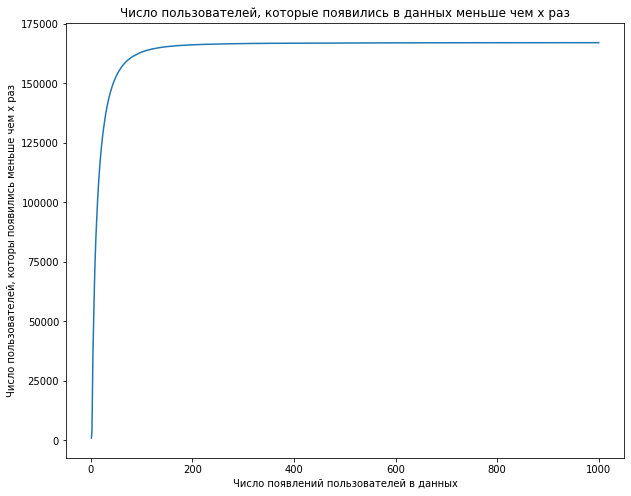

In [15]:
X = np.linspace(1,1000,num = 1000)
plt.figure(figsize = (10,8))
plt.plot(X,rasp)
plt.title('Число пользователей, которые появились в данных меньше чем x раз')
plt.xlabel('Число появлений пользователей в данных')
plt.ylabel('Число пользователей, которы появились меньше чем x раз')
plt.show()

Как можно заметить большее число пользователей входит в данные меньше, чем 10 раз в то время как в данных присутствуют пользователи которые встречаются более 1000 раз и кроме того есть пользователей который встретился в данных 674858 раза

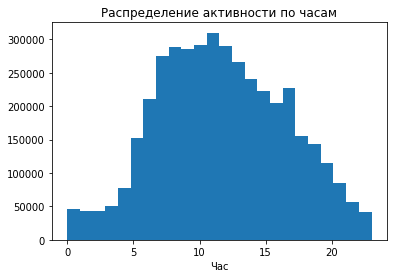

In [16]:
#Посмотрим на распределение часов
plt.hist(data['hour'],bins = 24)
plt.title('Распределение активности по часам')
plt.xlabel('Час')
plt.show()

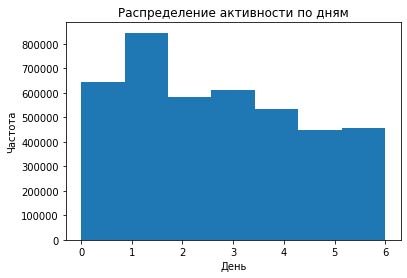

In [17]:
#Посмотрим на распределение дней
plt.hist(data['weekday'],bins = 7)
plt.title('Распределение активности по дням')
plt.xlabel('День')
plt.ylabel('Частота')
plt.show()

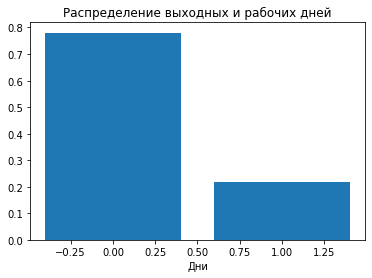

In [18]:
#Посмотрим на распределение выходных и рабочих дней
week = pd.DataFrame(data['is_weekend'].value_counts(normalize = True)).reset_index()
plt.bar(week['index'],week['is_weekend'])
plt.title('Распределение выходных и рабочих дней')
plt.xlabel('Дни')
plt.show()

# Подготовим данные и проведем кластеризацию

Кластеризация будет проводится методом k-средних, поскольку она обладает линейной временной сложностью (O(n)) и потому будет хорошо работать на данных из этой задачи. 

In [19]:
#Подготовим данные для кластеризации

data_proc = data.drop(['date','event_id','cookie_id','session_id'], axis = 1)

data_proc['event_type'] = labelencoder.fit_transform(data_proc['event_type'])
data_proc = pd.concat([pd.get_dummies(data_proc['event_type'], prefix = 'event_type'), data_proc.drop('event_type', axis = 1)], axis =1)

data_proc = pd.concat([pd.get_dummies(data_proc['domain_id'], prefix = 'domain'), data_proc.drop('domain_id', axis = 1)], axis =1)

data_proc = pd.concat([pd.get_dummies(data_proc['weekday'], prefix = 'wd'), data_proc.drop('weekday', axis = 1)], axis =1)


In [20]:
data_proc.head()

,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,domain_0,domain_1,domain_2,domain_3,domain_4,domain_5,domain_6,domain_7,domain_8,event_type_0,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_16,event_type_17,event_type_18,event_type_19,event_type_20,event_type_21,hour,is_weekend
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Подбор числа кластеров будем проводить локтевым методом

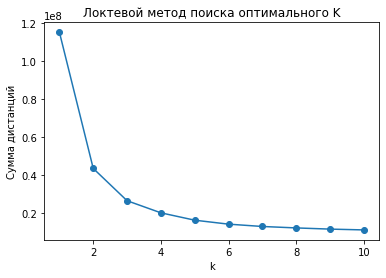

In [22]:
K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42, n_init = 40).fit(data_proc) for k in K]
dist = [model.inertia_ for model in models]


plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Сумма дистанций')
plt.title('Локтевой метод поиска оптимального K')
plt.show()

Заметно что для данных оптимальным числом кластеров является 3

In [23]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(data_proc)
data['cluster'] = model.labels_
data


,event_id,cookie_id,session_id,domain_id,hour,weekday,is_weekend
cluster,,,,,,,
0,2.062121e+06,87052.111564,120481.158200,3.537131,17.810182,2.727483,0.257531
1,2.061921e+06,87550.686104,122885.641321,3.647389,5.769293,2.693730,0.214280
2,2.062864e+06,85479.618579,120889.913807,3.303741,11.404131,2.583004,0.195069


In [26]:
data

,date,event_id,cookie_id,session_id,event_type,domain_id,hour,weekday,is_weekend,cluster
0,2020-08-18 00:00:01.065710,147840,102982,231455,read_block ...,6,0,1,0,1
1,2020-08-18 00:00:01.066429,1270509,102982,231455,read_block ...,6,0,1,0,1
2,2020-08-18 00:00:02.582822,3572350,102982,231455,read_block ...,6,0,1,0,1
3,2020-08-18 00:00:02.582836,2630228,102982,231455,read_block ...,6,0,1,0,1
4,2020-08-18 00:00:03.225834,2419045,119943,126137,read_block ...,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
4124729,2020-09-08 23:59:53.341022,2710941,91212,179406,read_block ...,6,23,1,0,0
4124730,2020-09-08 23:59:53.447630,2821711,77964,31204,hover ...,3,23,1,0,0
4124731,2020-09-08 23:59:53.534833,1853980,77964,31204,click ...,3,23,1,0,0
4124732,2020-09-08 23:59:53.795669,2584670,91212,179406,read_block ...,6,23,1,0,0
